<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [1]:
import gc
import pickle
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from utilities import *
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate, KFold
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import export_graphviz

pd.options.mode.chained_assignment = None
%matplotlib inline
%load_ext autoreload
%autoreload 2

df = pd.read_csv('data/network_backup_dataset.csv')
from sklearn.neural_network import MLPRegressor

df.drop('Backup Time (hour)', axis=1, inplace=True)
df.columns = ['week', 'dow', 'hod', 'id', 'name', 'target']

dayOfWeek={'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3, 'Friday': 4, 'Saturday': 5, 'Sunday': 6}
df['dow'] = df['dow'].map(dayOfWeek)

features = df.columns.values.tolist()[:5]

lb_en = LabelEncoder()
for feature in features:  # Just label-encode everything.
    df[feature] = lb_en.fit_transform(df[feature])


from itertools import chain, combinations
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

nfolds = 10
seed = 42

## (c) Neural Network

### One hot encoding
Multi-layer Perceptron is sensitive to feature scaling, so it is highly recommended to scale the data. For example, scale each attribute on the input vector X to [0, 1] or [-1, +1], or standardize it to have mean 0 and variance 1.
One-hot-encoding transforms categorical features to a format that works better with classification and regression algorithms. 

In [2]:
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
x = enc.fit_transform(df[features])
y = df['target']

### Relu

The Relu activation (the rectified linear unit function, returns f(x) = max(0, x)) is simply thresholded at zero.  It was found to greatly accelerate the convergence of stochastic gradient descent compared to other functions. It is argued that this is due to its linear, non-saturating form. Compared to tanh/sigmoid neurons that involve expensive operations (exponentials, etc.), the ReLU can be implemented by simply thresholding a matrix of activations at zero.

In [3]:
layerunits =(1,2,3,4,5,6,7,8,9,10,20,50,75,100,200,300,400,600,800)
size = len(layerunits)
trn_rmses_relu = np.zeros((size, ))
tst_rmses_relu = np.zeros((size, ))
n = 0
for i in layerunits:
    clf = MLPRegressor(hidden_layer_sizes=(i, ),activation='relu',shuffle=False)
    y_pred, trn_rmse_relu = cross_validate_custom(nfolds, seed, x, y, clf)
    tst_rmse_relu = np.sqrt(mean_squared_error(y, y_pred))
    trn_rmses_relu[n] = trn_rmse_relu
    tst_rmses_relu[n] = tst_rmse_relu
    n = n+1

## Tanh
Tanh, is the hyperbolic tan function, returns f(x) = tanh(x). Like the logistic sigmoid, the tanh function is also sigmoidal (“s”-shaped), but instead outputs values that range (-1, 1). Thus strongly negative inputs to the tanh will map to negative outputs. Additionally, only zero-valued inputs are mapped to near-zero outputs.

In [4]:
layerunits =(1,2,3,4,5,6,7,8,9,10,20,50,75,100,200,300,400,600,800)
size = len(layerunits)
trn_rmses_tanh = np.zeros((size, ))
tst_rmses_tanh = np.zeros((size, ))
n = 0
for i in layerunits:
    clf = MLPRegressor(hidden_layer_sizes=(i, ),activation='tanh',shuffle=False)
    y_pred, trn_rmse_tanh = cross_validate_custom(nfolds, seed, x, y, clf)
    tst_rmse_tanh = np.sqrt(mean_squared_error(y, y_pred))
    trn_rmses_tanh[n] = trn_rmse_tanh
    tst_rmses_tanh[n] = tst_rmse_tanh
    n = n+1
print(tst_rmses_tanh)


[ 0.09427633  0.09001271  0.09059901  0.09056081  0.09212787  0.09167616
  0.08679141  0.0896893   0.08964956  0.08971491  0.08078507  0.08426282
  0.07508466  0.07975821  0.08374214  0.08445198  0.09159137  0.0927146
  0.09318492]


## Logistic
‘logistic’ is the logistic sigmoid function, returns f(x) = 1 / (1 + exp(-x)). This is often used as the output activation function for binary classification problems (i.e. outputs values that range (0, 1)).

In [5]:
layerunits =(1,2,3,4,5,6,7,8,9,10,20,50,75,100,200,300,400,600,800)
size = len(layerunits)
trn_rmses_logi = np.zeros((size, ))
tst_rmses_logi = np.zeros((size, ))
n = 0
for i in layerunits:
    clf = MLPRegressor(hidden_layer_sizes=(i, ),activation='logistic',shuffle=False)
    y_pred, trn_rmse_logi = cross_validate_custom(nfolds, seed, x, y, clf)
    tst_rmse_logi = np.sqrt(mean_squared_error(y, y_pred))
    trn_rmses_logi[n] = trn_rmse_logi
    tst_rmses_logi[n] = tst_rmse_logi
    n = n+1
print(tst_rmses_logi)


[ 0.09241221  0.09229166  0.0899986   0.08925631  0.08946962  0.08866522
  0.08879569  0.08869576  0.0887298   0.08870075  0.08869813  0.08894233
  0.08891424  0.08887562  0.08870328  0.09083596  0.08969344  0.0911828
  0.09204593]


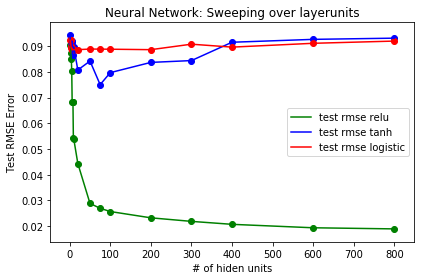

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(layerunits,tst_rmses_relu, '-',color='g')
ax.plot(layerunits,tst_rmses_tanh, '-',color='b')
ax.plot(layerunits,tst_rmses_logi, '-',color='r')
ax.set_xlabel('# of hiden units')
ax.set_ylabel('Test RMSE Error')
ax.scatter(layerunits,tst_rmses_relu, marker='o', color='g')
ax.scatter(layerunits,tst_rmses_tanh, marker='o', color='b')
ax.scatter(layerunits,tst_rmses_logi, marker='o', color='r')
ax.legend(['test rmse relu','test rmse tanh','test rmse logistic'])
ax.set_title('Neural Network: Sweeping over layerunits')
fig.tight_layout()
filename = '2-c'
fig.savefig('report/figures/'+filename, dpi=300)

## Plot the Neural Network result with the best parameter
The best parameters combination for the neural network is Rectifier with 800 hidden units for 1 layer setting. The Test RMSE for it is 0.018952. The trend is that Rectifier works better than other algorithms in this situation, and the more hidden units were employed, the lower the Test RMSE is. The results show that the rectifier performs best while treating sparse dataset.

train rmse: 0.069704
test rmse: 0.071911


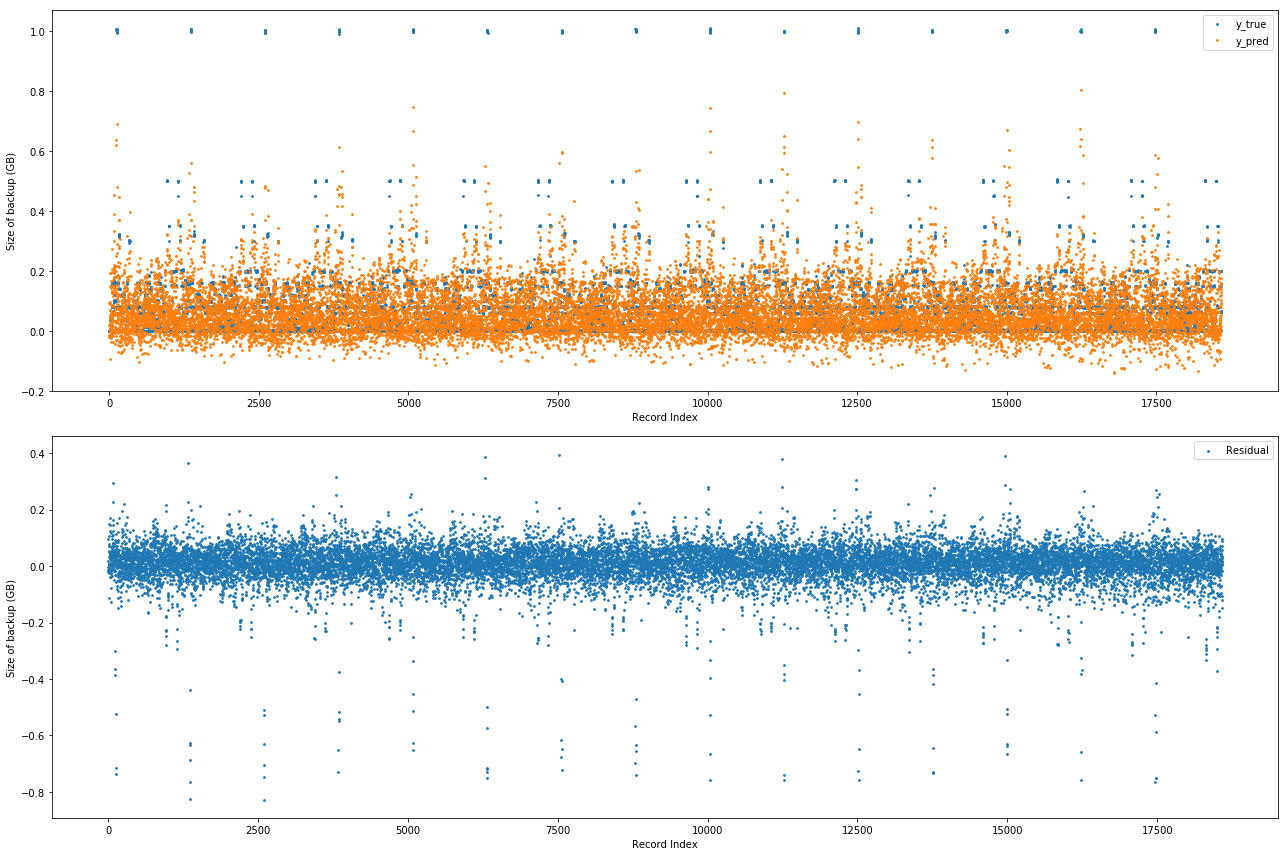

In [15]:
from sklearn.neural_network import MLPRegressor

clf = MLPRegressor(hidden_layer_sizes=(800),activation='relu',shuffle=False)
y_pred, trn_rmse = cross_validate_custom(nfolds, seed, x.values, y, clf)
tst_rmse = np.sqrt(mean_squared_error(y, y_pred))
evaluate_results(trn_rmse, tst_rmse, y_true=y, y_pred=y_pred, filename="2-c-best.png")

## (e) knn
In this part we employed k-nearest neighbor algorithm. K nearest neighbors is a simple algorithm that stores all available cases and predict the numerical target based on a similarity measure (e.g., distance functions). Knn algorithm is used when none of the independent variables had disproportionately large variance to confer to the model either individually or possibly by mutual interaction. Knn regressor gets the benefit of extremely low bias using local methods. 

0.0402081314602


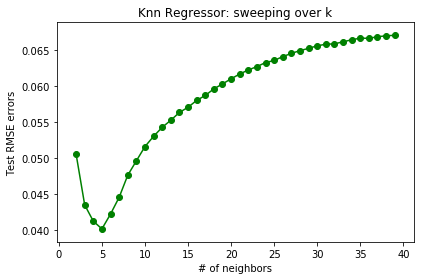

In [19]:
from sklearn.neighbors import KNeighborsRegressor
n_value = range(2,40)
size_n = len(n_value)
trn_rmses_knn = np.zeros((size_n, ))
tst_rmses_knn = np.zeros((size_n, ))
seed = 42
nfolds = 10
x = df[features]
y = df['target']
n = 0
for i in n_value:
    clf_knn = KNeighborsRegressor(n_neighbors=i)
    y_pred, trn_rmse_knn = cross_validate_custom(nfolds, seed, x.values, y, clf_knn)
    tst_rmse_knn = np.sqrt(mean_squared_error(y, y_pred))
    tst_rmses_knn[n] = tst_rmse_knn
    n = n+1
print(np.min(tst_rmses_knn))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('# of neighbors')
ax.set_ylabel('Test RMSE errors')
ax.plot(n_value,tst_rmses_knn, '-',color='g')
ax.scatter(n_value,tst_rmses_knn, marker='o', color='g')
ax.set_title('Knn Regressor: sweeping over k')
fig.tight_layout()
filename = '2-e'
fig.savefig('report/figures/'+filename, dpi=300)

The best setting for the K-Nearest Neighbors Regressor algorithm is having 5 neighbors. The Test RMSE accordingly is 0.0402081314602
